In [28]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import os
import glob
import seaborn as sn
import pandas as pd
import mediapipe as mp

from dataProcess import getDataLoader
from dataProcess import plot_images
from modelProcess import count_params
from modelProcess import modelTrain
from modelEvaluation import plotCurve
from modelEvaluation import applyModeltoTest

from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

In [29]:
# set up the device
if torch.cuda.is_available():
    device = torch.device('cuda')          
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_built():
    device = 'mps' 
    print(f'using {device}')
else:
    device = torch.device('cpu')
    print(f'using {device}')

Using GPU: NVIDIA GeForce RTX 3090


In [3]:
# function to process images by mediapipe
def process_images(input_folder, output_folder):
    # create mediapipe model
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, 
                           max_num_hands=1, 
                           min_detection_confidence=0.5)
    
    # go through each subfolder
    for class_folder in os.listdir(input_folder):
        input_class_path = os.path.join(input_folder, class_folder)
        output_class_path = os.path.join(output_folder, class_folder)

        # create output subfolder
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        for image_path in glob.glob(os.path.join(input_class_path, '*.jpg')):
            # read and convert the image to rgb
            image = Image.open(image_path)
            image_rgb = np.array(image.convert('RGB'))

            # process through mediapipe model
            results = hands.process(image_rgb)
            if results.multi_hand_landmarks:
                # drop the marks on image
                for hand_landmarks in results.multi_hand_landmarks:
                    mp.solutions.drawing_utils.draw_landmarks(image_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # save the output image
            image_mp = Image.fromarray(image_rgb)
            base_name = os.path.basename(image_path)
            image_mp.save(os.path.join(output_class_path, base_name))

In [4]:
input_folder = '../data/asl_alphabet_train'
output_folder = '../data/asl_alphabet_train_mp'
process_images(input_folder, output_folder)

I0000 00:00:1701936249.786748    6257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1701936249.838260    6385 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.129.03), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [30]:
folder = '../data/asl_alphabet_train_mp'
loader_train, loader_val, loader_test=getDataLoader(folder,batch_size=32)

dataset
training dataset size: 60900
validation dataset size: 13050
test dataset size: 13050


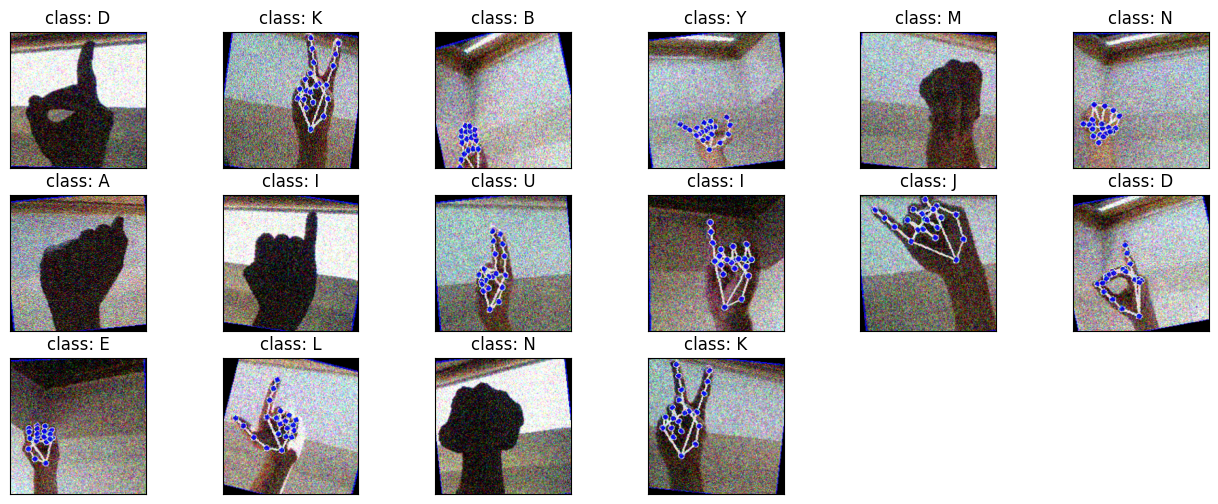

In [31]:
plot_images(loader_train,16)

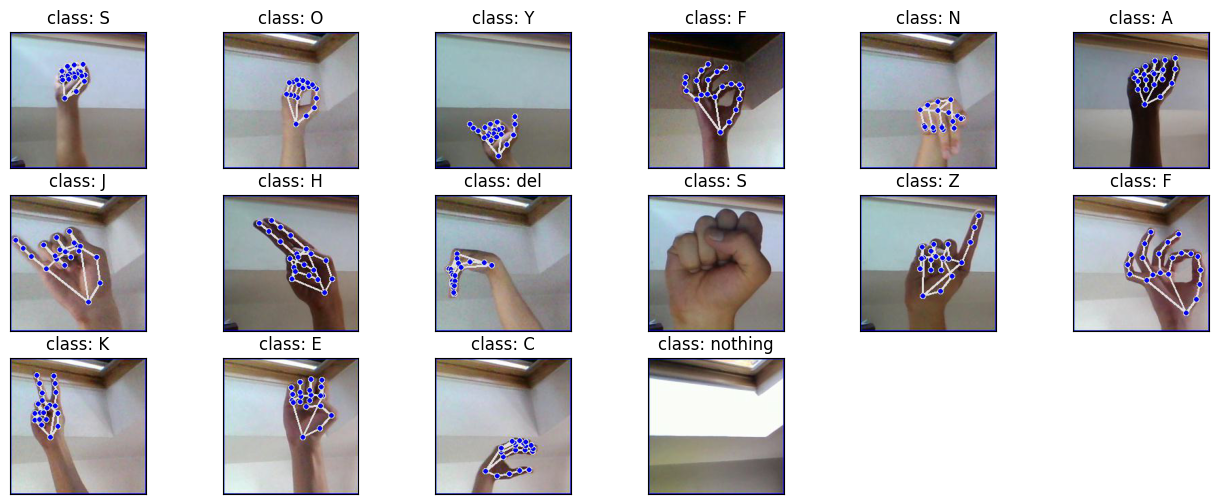

In [32]:
plot_images(loader_test,16)

In [33]:
class skeletonCNN(nn.Module):
    def __init__(self):
        super(skeletonCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=5)
        
        self.fc1 = nn.Linear(32 * 20 * 20, 512)
        self.fc2 = nn.Linear(512, 29)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [34]:
class skeletonCNN(nn.Module):
    def __init__(self):
        super(skeletonCNN, self).__init__()
        
        # block1, 200x200
        self.conv1a = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(8)
        self.conv1b = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # block2, 100x100
        self.conv2a = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(32)
        self.conv2b = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # block3, 50x50
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=5)

        self.dropout = nn.Dropout2d(0.3)
        
        # linear layers, 25x25
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 29)
        
        self.flatten = nn.Flatten()
        
        
    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        
        x = self.dropout(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [35]:
model = skeletonCNN()
count_params(model)

conv1a.weight: 216
conv1a.bias: 8
bn1a.weight: 8
bn1a.bias: 8
conv1b.weight: 1152
conv1b.bias: 16
bn1b.weight: 16
bn1b.bias: 16
conv2a.weight: 4608
conv2a.bias: 32
bn2a.weight: 32
bn2a.bias: 32
conv2b.weight: 18432
conv2b.bias: 64
bn2b.weight: 64
bn2b.bias: 64
conv3a.weight: 73728
conv3a.bias: 128
bn3a.weight: 128
bn3a.bias: 128
conv3b.weight: 147456
conv3b.bias: 128
bn3b.weight: 128
bn3b.bias: 128
fc1.weight: 6553600
fc1.bias: 512
fc2.weight: 14848
fc2.bias: 29
total number of trainable params: 6815709


In [36]:
num_epochs=20
losses_train, accs_train, losses_val, accs_val, train_time=modelTrain(model=model,learning_rate=0.00015,num_epochs=num_epochs,loader_train=loader_train,loader_val=loader_val,device=device)
train_time

epoch [1/20] - train loss: 1.90, train acc: 0.42, time taken: 145.14
epoch [1/20], val loss: 0.91, val acc: 0.70, time taken: 11.25
model saved with val acc: 0.7006896551724138
epoch [2/20] - train loss: 0.85, train acc: 0.71, time taken: 150.21
epoch [2/20], val loss: 0.59, val acc: 0.79, time taken: 11.28
model saved with val acc: 0.7935632183908046
epoch [3/20] - train loss: 0.57, train acc: 0.81, time taken: 152.99
epoch [3/20], val loss: 0.43, val acc: 0.84, time taken: 12.00
model saved with val acc: 0.8418390804597701
epoch [4/20] - train loss: 0.44, train acc: 0.85, time taken: 152.43
epoch [4/20], val loss: 0.41, val acc: 0.85, time taken: 11.43
model saved with val acc: 0.8524137931034482
epoch [5/20] - train loss: 0.35, train acc: 0.88, time taken: 152.21
epoch [5/20], val loss: 0.33, val acc: 0.89, time taken: 11.43
model saved with val acc: 0.8859770114942529
epoch [6/20] - train loss: 0.30, train acc: 0.90, time taken: 153.41
epoch [6/20], val loss: 0.23, val acc: 0.92, t

3024.1393921375275

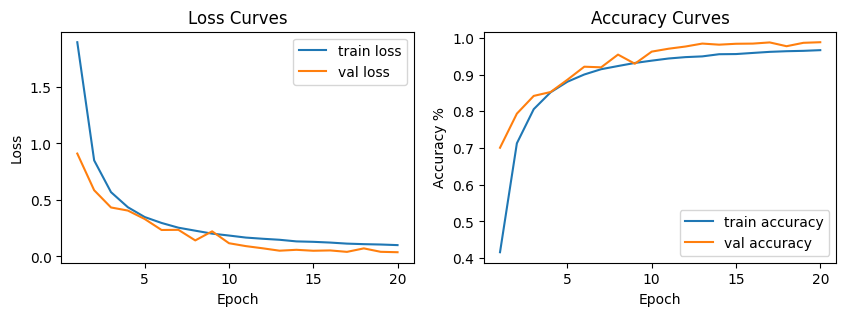

In [37]:
plotCurve(num_epochs, losses_train, accs_train, losses_val, accs_val)

test loss: 0.0364, test acc: 0.9879


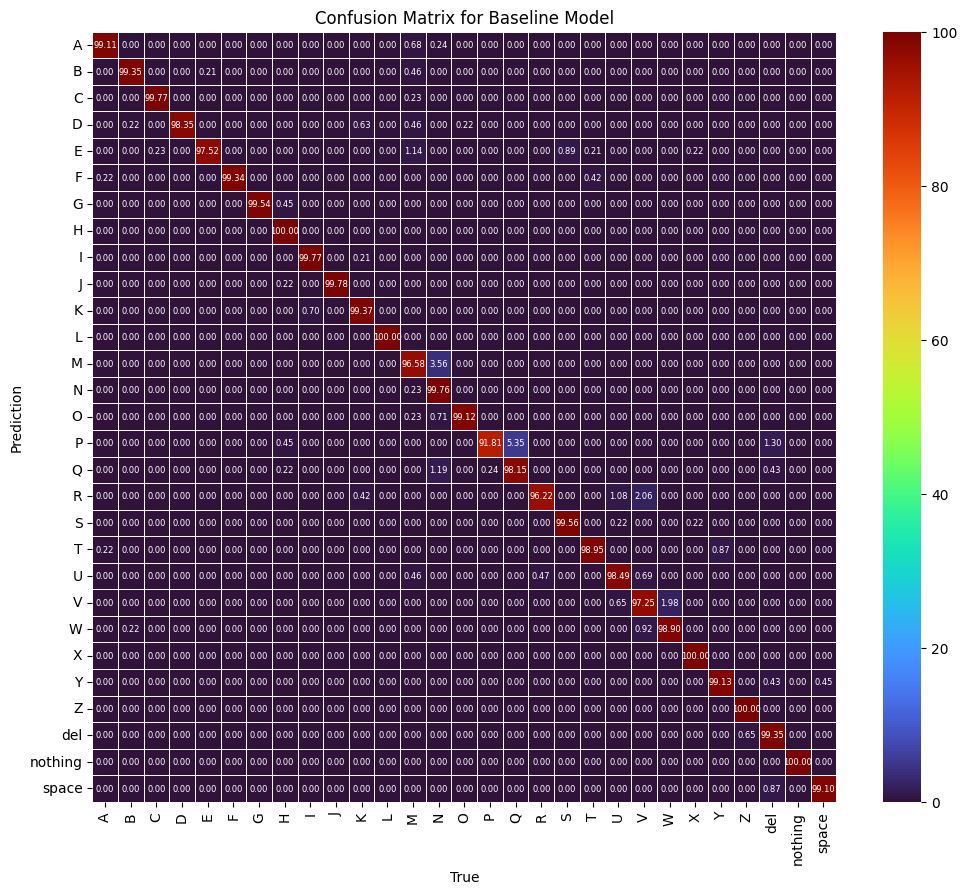

Precision and Recall for each class of Baseline Model
class 1: precision = 1.00, recall = 0.99
class 2: precision = 1.00, recall = 0.99
class 3: precision = 1.00, recall = 1.00
class 4: precision = 1.00, recall = 0.98
class 5: precision = 1.00, recall = 0.97
class 6: precision = 1.00, recall = 0.99
class 7: precision = 1.00, recall = 1.00
class 8: precision = 0.99, recall = 1.00
class 9: precision = 0.99, recall = 1.00
class 10: precision = 1.00, recall = 1.00
class 11: precision = 0.99, recall = 0.99
class 12: precision = 1.00, recall = 1.00
class 13: precision = 0.96, recall = 0.96
class 14: precision = 0.95, recall = 1.00
class 15: precision = 1.00, recall = 0.99
class 16: precision = 1.00, recall = 0.93
class 17: precision = 0.95, recall = 0.98
class 18: precision = 1.00, recall = 0.96
class 19: precision = 0.99, recall = 1.00
class 20: precision = 0.99, recall = 0.99
class 21: precision = 0.98, recall = 0.98
class 22: precision = 0.96, recall = 0.97
class 23: precision = 0.98, rec

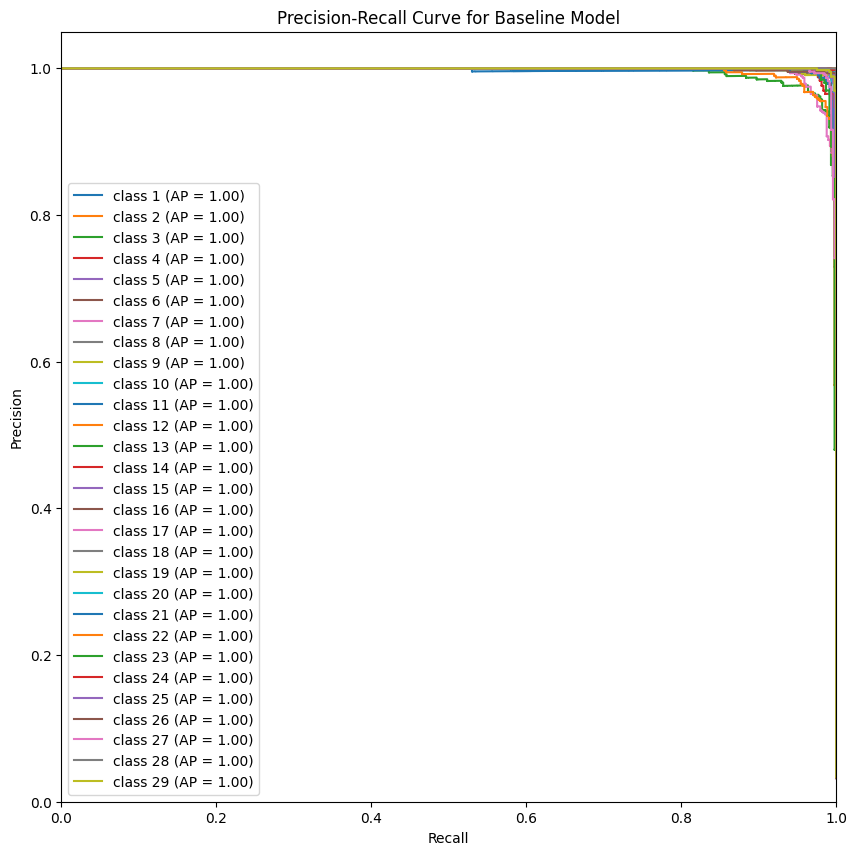

(0.036410809793225925, 0.9878927203065134, 12.10677433013916)

In [38]:
applyModeltoTest(model=model,loader_test=loader_test,device=device)